In [ ]:
!pip install ultralytics
!pip install opencv-python

In [46]:
import math
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
import numpy as np


0: 640x512 1 person, 6 birds, 2964.5ms
Speed: 6.2ms preprocess, 2964.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


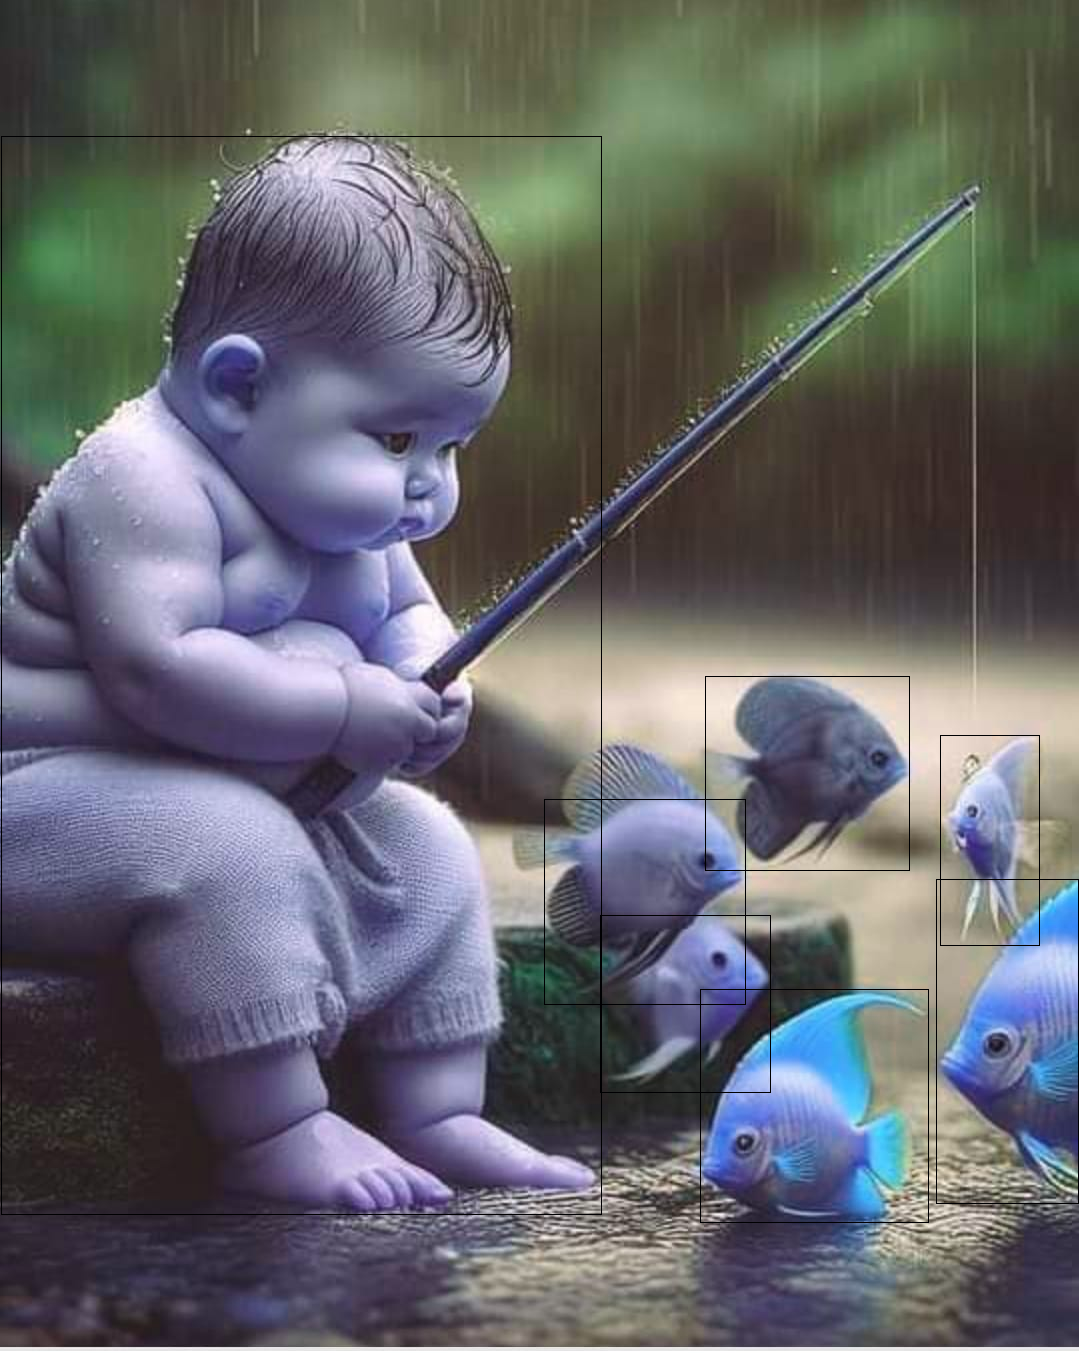

[[1, 136, 601, 1214, 'person', 0.94, 0], [544, 799, 745, 1004, 'bird', 0.32, 410.7615], [600, 915, 770, 1092, 'bird', 0.46, 505.0149], [705, 676, 909, 870, 'bird', 0.76, 515.4028], [700, 989, 928, 1222, 'bird', 0.76, 669.3796], [940, 735, 1039, 945, 'bird', 0.84, 707.509], [936, 879, 1078, 1203, 'bird', 0.85, 795.2308]]


In [47]:
model = YOLO("yolov8l.pt")

def yolo8_bounding_boxes_with_distance(model, image_path):
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    bboxes = model.predict(frame)
    result = bboxes[0]

    img_height, img_width, _ = frame.shape

    bounding_boxes = []
    box_sizes = []
    i = 0
    for box in result.boxes:
        class_id = result.names[box.cls[0].item()]
        cords = box.xyxy[0].tolist()
        x1, y1, x2, y2  = [round(x) for x in cords]
        box_width = round(x2 - x1, 4)
        box_height = round(y2 - y1, 4)
        total_box = round(box_height * box_width, 4)
        cX, cY = x1 + int((x2-x1)/2), y1 + int((y2-y1)/2) # center X and center Y
        conf = round(box.conf[0].item(), 2)

        #print("Object type:", class_id)
        #print("Coordinates:",  x1, y1, x2, y2)
        #print("Box width, height and total box:",  box_width, box_height, total_box )
        #print("Probability:", conf)
        #print("---")

        cv2.rectangle(frame, (x1, y1),(x2, y2), 2)
        bounding_boxes.append([
          x1, y1, x2, y2, class_id, conf, total_box, cX, cY
        ])
        box_sizes.append(total_box)
        i=i+1

    cv2_imshow(frame)


    update_bbox = {}
    distance = []
    for bbox in bounding_boxes:

        if bbox[6] == max(box_sizes):
            source_box = bbox
            for i in range(len(bounding_boxes)):
                if source_box[7] != bounding_boxes[i][7] and source_box[8] != bounding_boxes[i][8] :

                    dist = math.sqrt((source_box[7] - bounding_boxes[i][7])** 2 + (source_box[8] - bounding_boxes[i][8])** 2)
                    update_bbox[i] = {index: element for index, element in enumerate(bounding_boxes[i])}
                    update_bbox[i][len(update_bbox[i])] = round(dist, 4)
                    distance.append(round(dist, 4))
                else:
                    update_bbox[i] = {index: element for index, element in enumerate(bounding_boxes[i])}
                    update_bbox[i][len(update_bbox[i])] = 0
                    distance.append(0)


    #print(update_bbox)
    #print(bboxes)

    #print("Sorted distance values : ", sorted(distance))

    final_bbox = []
    for i in range(len(sorted(distance))):
        for key, val in update_bbox.items():
            if sorted(distance)[i] == val[9] :
                del val[8]
                del val[7]
                del val[6]
                final_bbox.append(list(val.values()))
                #print(list(val.values()))

    print(final_bbox)

    return final_bbox

final_bbox = yolo8_bounding_boxes_with_distance(model, "/content/babyCatchingFish.jpg")
